In [1]:
# Let's import the needed packages

# To deal with arrays 
import xarray as xr
import pandas as pd 
pd.options.mode.chained_assignment = None
import numpy as np

# To plot curves
import matplotlib.pyplot as plt

# To plot the map
import cartopy.crs as ccrs

# Importing Models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Prediction Scores
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Dimensionality reduction 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#import our useful functions 
import useful_functions

# 1. One-month prediction

In [2]:
# Get the data for a 1-month prediction, split and scale the data

X, y = useful_functions.get_data("data/preprocessed_data/nino_dataset_1m_seasonal.npz")
X_train, X_test, y_train, y_test= useful_functions.split_scale_data(X, y, RANDOM_SPLIT = False, train_size = 374)

==== GET THE DATA ====
Shape of X: (474, 64800)
Shape of y: (474,)
First 25 elements of y: [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
==== SPLIT & SCALE THE DATA ====
Shape of X_train: (374, 64800)
Shape of y_train: (374,)
Shape of X_test: (100, 64800)
Shape of y_test: (100,)


The problem here is that we have a small amount of data and the data are in high dimension. 
**=> High risk of overfitting**

Let us try to first simple model so we can have a baseline.

## 1. Baseline n°1 - LDA

### 1.1 First evaluation

In [3]:
# Define the classifier
lda = LinearDiscriminantAnalysis()

# Fit the model on the data
lda.fit(X_train,y_train)

# Get the prediction
y_test_pred_lda = lda.predict(X_test)
y_train_pred_lda = lda.predict(X_train)

# Computation of the AUC and accuracy
roc_auc_score_lda_test = roc_auc_score(y_test, lda.predict_proba(X_test)[:, 1])
accuracy_score_lda_test = accuracy_score(y_test, y_test_pred_lda)
roc_auc_score_lda_train = roc_auc_score(y_train, lda.predict_proba(X_train)[:, 1])
accuracy_score_lda_train = accuracy_score(y_train, y_train_pred_lda)

# Print the results
print("==== TRAIN ====")
print(f"Accuracy for TRAIN data: {accuracy_score_lda_train:.3f}")
print(f"     AUC for TRAIN data: {roc_auc_score_lda_train:.3f}")
print("==== TEST ====")
print(f"Accuracy for TEST data: {accuracy_score_lda_test:.3f}")
print(f"     AUC for TEST data: {roc_auc_score_lda_test:.3f}")


==== TRAIN ====
Accuracy for TRAIN data: 0.976
     AUC for TRAIN data: 0.998
==== TEST ====
Accuracy for TEST data: 0.610
     AUC for TEST data: 0.628


Overfitting !!!
Before trying this model, we will try to reduce the overfitting by performing dimensionality reduction.

### 1.2 Dimensionality reduction: PCA

Text(0.5, 1.0, 'Cumulative Explained Variance by Principal Components')

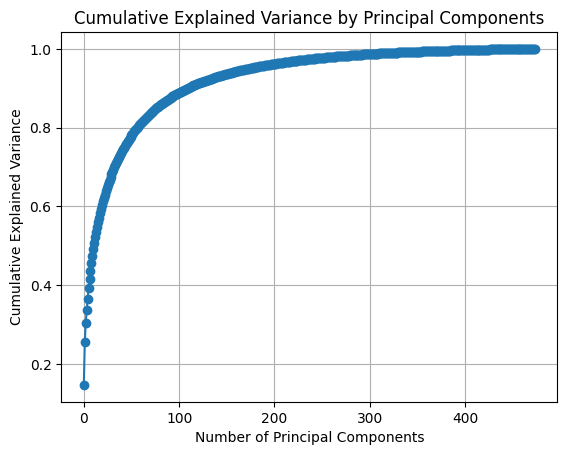

In [4]:
# PCA
PCA_sst = PCA(n_components = None)
PCA_sst.fit(X)

# Computation of the explained variance ratio
explained_variance_ratio_sst = PCA_sst.explained_variance_ratio_

# Plot of the explained variance ratio
plt.grid()
plt.plot(np.cumsum(explained_variance_ratio_sst), marker = 'o')

plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')

In [5]:
# Perform several LDA with different value of p to get a validation curve for this parameter
p_values = np.linspace(1, 100, 100).astype(int)
p_values = p_values.astype(int)
test_score_accuracy = []
train_score_accuracy = []

for p in p_values:
    # PCA with p principal components
    PCA_sst = PCA(n_components=p)
    PCA_sst.fit(X)

    # Project data
    Xp_sst = PCA_sst.transform(X)
    X_train, X_test, y_train, y_test = useful_functions.split_scale_data(Xp_sst, y, RANDOM_SPLIT = False, train_size = 374, verbose = False)

    # Define the classifier
    lda = LinearDiscriminantAnalysis()

    # Fit the model on the data
    lda.fit(X_train,y_train)

    # Get the prediction
    y_test_pred_lda = lda.predict(X_test)
    y_train_pred_lda = lda.predict(X_train)

    # Computation of the accuracy
    test_score_accuracy.append(accuracy_score(y_test, y_test_pred_lda))
    train_score_accuracy.append(accuracy_score(y_train, y_train_pred_lda))


In [6]:
# Get the best score
best_index = np.argsort(-np.array(test_score_accuracy))[0]
best_p_value = p_values[best_index]
best_test_score_pca = test_score_accuracy[best_index]
best_train_score_pca = train_score_accuracy[best_index]

# Prints
print(f"Best value of p - PCA : {best_p_value}")
print(f"Train Score for the best p: {best_train_score_pca}")
print(f"Test Score for the best p: {best_test_score_pca}")
print(f"Amélioration tu score de test: + {best_test_score_pca - accuracy_score_lda_test:.2f}")

Best value of p - PCA : 48
Train Score for the best p: 0.8556149732620321
Test Score for the best p: 0.84
Amélioration tu score de test: + 0.23


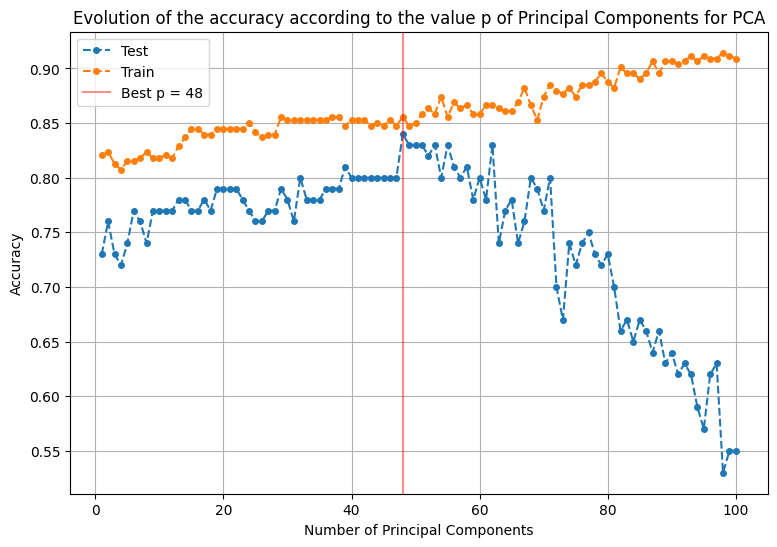

In [7]:
# Plot the validation curve
plt.figure(figsize=(9,6))
plt.plot(p_values, test_score_accuracy, 'o', markersize=4, ls='--', label="Test")
plt.plot(p_values, train_score_accuracy, 'o', markersize=4, ls='--', label="Train")
plt.axvline(x = best_p_value, color = 'red', linestyle = '-', label = f'Best p = {best_p_value}', alpha = 0.45)
plt.title("Evolution of the accuracy according to the value p of Principal Components for PCA")
plt.xlabel("Number of Principal Components")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

Test accuracy with the best p: 0.81
Test auc with the best p: 0.86


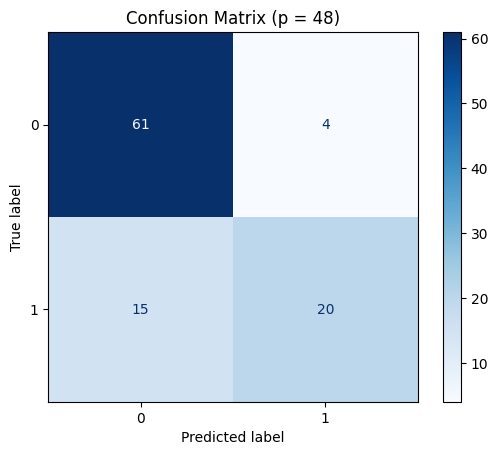

In [10]:
# PCA with the best value of p
PCA_sst = PCA(n_components = best_p_value)
PCA_sst.fit(X)

Xp_sst = PCA_sst.transform(X)
X_train, X_test, y_train, y_test = useful_functions.split_scale_data(
    Xp_sst, y, RANDOM_SPLIT = False, train_size = 374, verbose = False
)

# Make predictions 
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_test_pred_lda = lda.predict(X_test)

# Print the scores
test_accuracy = accuracy_score(y_test, y_test_pred_lda)
roc_auc_score_lda_test = roc_auc_score(y_test, lda.predict_proba(X_test)[:, 1])
print(f"Test accuracy with the best p: {test_accuracy:.2f}")
print(f"Test auc with the best p: {roc_auc_score_lda_test:.2f}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_lda)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=lda.classes_)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix (p = {best_p_value})")
plt.show()

## 2. Linear Regression, Ridge and Lasso

## 3. Test Different Models

QDA - Accuracy: 0.65, AUC: 0.5213186813186813

---------------------
QDA cross val - Best Parameters: {'reg_param': 0.9}
QDA cross val - Tuned Accuracy: 0.73, Tuned AUC: 0.8026373626373626

---------------------
LogisticRegression - Accuracy: 0.81, AUC: 0.8096703296703297

---------------------
LogisticRegression cross val - Best Parameters: {'C': 0.01}
LogisticRegression cross val - Tuned Accuracy: 0.69, Tuned AUC: 0.796923076923077

---------------------
RandomForestClassifier - Accuracy: 0.76, AUC: 0.75010989010989

---------------------
RandomForestClassifier cross val - Best Parameters: {'max_depth': None, 'n_estimators': 100}
RandomForestClassifier cross val - Tuned Accuracy: 0.77, Tuned AUC: 0.8032967032967032

---------------------
SVC - Accuracy: 0.71, AUC: 0.8483516483516483

---------------------
SVC cross val - Best Parameters: {'C': 0.1, 'kernel': 'rbf'}
SVC cross val - Tuned Accuracy: 0.65, Tuned AUC: 0.8272527472527472

---------------------
MLPClassifier - Accuracy: 0.7

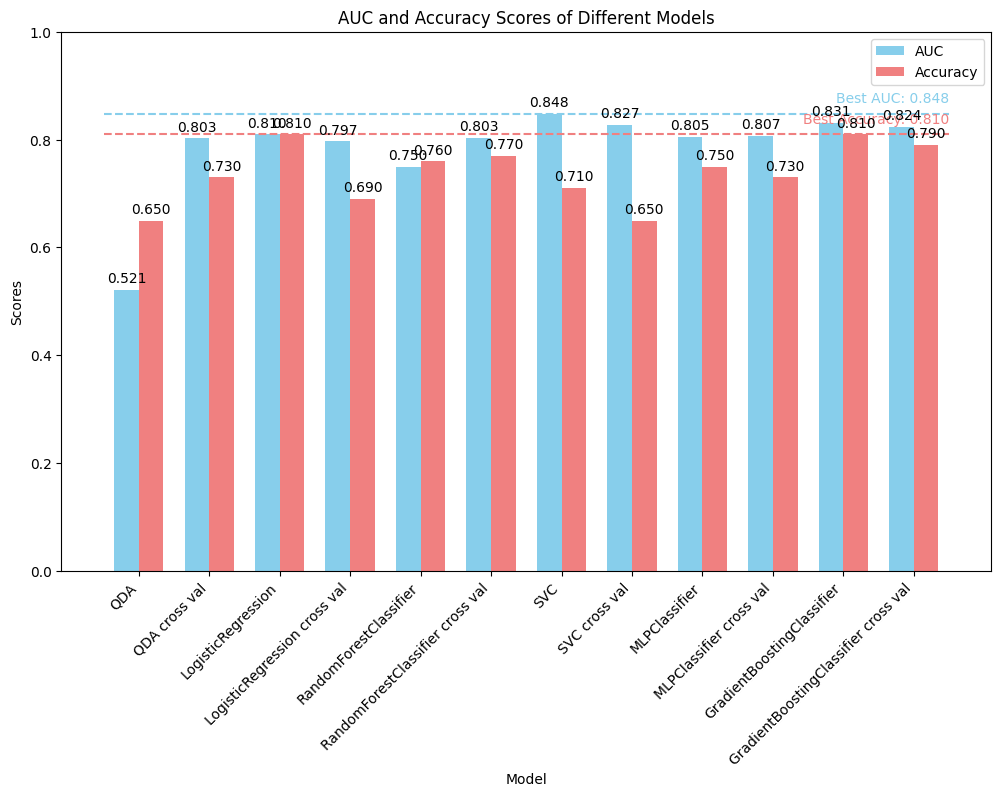

In [9]:
# The models that we are going to use 
models_names = ["QDA", "LogisticRegression", "RandomForestClassifier", "SVC", "MLPClassifier", "GradientBoostingClassifier"]
models = [QuadraticDiscriminantAnalysis(), LogisticRegression(), RandomForestClassifier(), SVC(probability = True), MLPClassifier(max_iter = 500), GradientBoostingClassifier()]

# The params of each model for cross validation
qda_params = {'reg_param': [0, 0.1, 0.2, 0.5, 0.7, 0.9]}
lr_params = {'C': [0.01, 0.1, 1, 10, 100]}
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
svc_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
mlp_params = {'hidden_layer_sizes': [(50,), (100,), (100, 50)], 'alpha': [0.0001, 0.001, 0.01]}
gb_params = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
param_grids = [ qda_params, lr_params, rf_params, svc_params, mlp_params, gb_params]

#initialisations of the scores list and names (for the legend of the plot)
model_names_legend = []
auc_scores = []
accuracy_scores = []
best_model_name = None
best_model = None
best_accuracy = 0
best_auc = 0

for i in range (len(models)) :
    #first evaluate the basic model
    model, accuracy, auc = useful_functions.evaluate_model(models[i], models_names[i],  X_train, y_train, X_test, y_test)
    print('\n---------------------')
    model_names_legend.append(models_names[i])
    auc_scores.append(auc)
    accuracy_scores.append(accuracy)

    if accuracy > best_accuracy or (accuracy == best_accuracy and auc > best_auc):
        best_model_name = models_names[i]
        best_model = model  
        best_accuracy = accuracy
        best_auc = auc

    #then tune the model 
    best_estimator_cv, best_params_cv, best_accuracy_cv, best_auc_cv = useful_functions.cross_validation(models[i], param_grids[i], X_train, y_train, X_test, y_test, models_names[i] + " cross val")
    print('\n---------------------')
    model_names_legend.append(models_names[i] + " cross val")
    auc_scores.append(best_auc_cv)
    accuracy_scores.append(best_accuracy_cv)

    if best_accuracy_cv > best_accuracy or (best_accuracy_cv == best_accuracy and best_auc_cv > best_auc):
        best_model_name = models_names[i] + " cross val"
        best_model = best_estimator_cv 
        best_accuracy = best_accuracy_cv
        best_auc = best_auc_cv

print(f"\nBest Model: {best_model_name}")
print(f"Best Accuracy: {best_accuracy:.4f}")
print(f"Best AUC: {best_auc:.4f}")

#now me plot the histograms 
useful_functions.plot_score(model_names_legend, auc_scores, accuracy_scores)

If we consider accuracy as the reference score, SVC seems to be the best model. Let's perform PCA on it. 

## 4) Perform PCA on the best estimator

In [ ]:
# Combine the best model with different values of

p_values = np.linspace(1, 100, 100).astype(int)
p_values = p_values.astype(int)
test_score_accuracy = []
train_score_accuracy = []
models_pca = []

for p in p_values:
    # PCA with p principal components
    PCA_sst = PCA(n_components=p)
    PCA_sst.fit(X)

    # Project data
    Xp_sst = PCA_sst.transform(X)
    X_train, X_test, y_train, y_test = useful_functions.split_scale_data(Xp_sst, y, RANDOM_SPLIT = False, train_size = 374, verbose = False)

    # Define the classifier
    model = best_model

    # Fit the model on the data
    model.fit(X_train,y_train)

    # Get the prediction
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # Computation of the accuracy
    test_score_accuracy.append(accuracy_score(y_test, y_test_pred))
    train_score_accuracy.append(accuracy_score(y_train, y_train_pred))
    models_pca.append(model)

In [ ]:
# Get the best score
best_index = np.argsort(-np.array(test_score_accuracy))[0]
best_p_value = p_values[best_index]
best_test_score_pca = test_score_accuracy[best_index]
best_train_score_pca = train_score_accuracy[best_index]
best_model_pca = models_pca[best_index]

# Prints
print(f"Best value of p - PCA : {best_p_value}")
print(f"Train Score for the best p: {best_train_score_pca}")
print(f"Test Score for the best p: {best_test_score_pca}")
print(f"Amélioration tu score de test: + {best_test_score_pca - accuracy_score_lda_test:.2f}")

Best value of p - PCA : 13
Train Score for the best p: 0.9224598930481284
Test Score for the best p: 0.93
Amélioration tu score de test: + 0.07


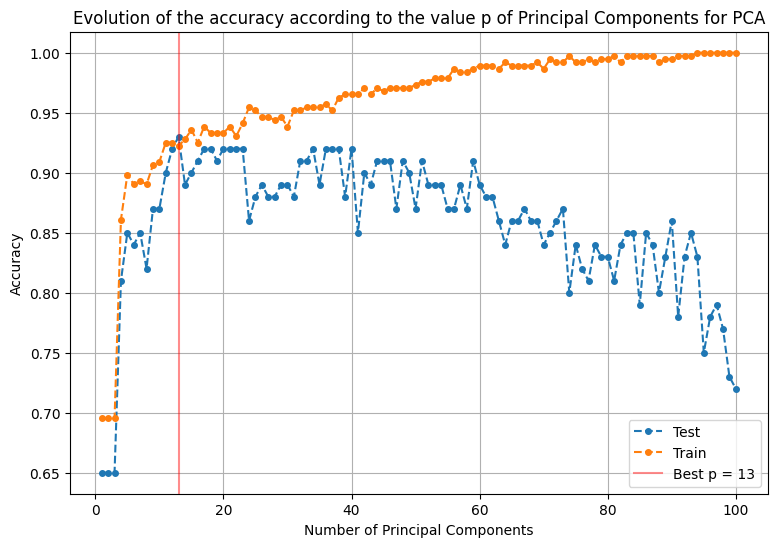

In [ ]:
# Plot the validation curve
plt.figure(figsize=(9,6))
plt.plot(p_values, test_score_accuracy, 'o', markersize=4, ls='--', label="Test")
plt.plot(p_values, train_score_accuracy, 'o', markersize=4, ls='--', label="Train")
plt.axvline(x = best_p_value, color = 'red', linestyle = '-', label = f'Best p = {best_p_value}', alpha = 0.45)
plt.title("Evolution of the accuracy according to the value p of Principal Components for PCA")
plt.xlabel("Number of Principal Components")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

Test accuracy with the best p: 0.92
Test auc with the best p: 0.97


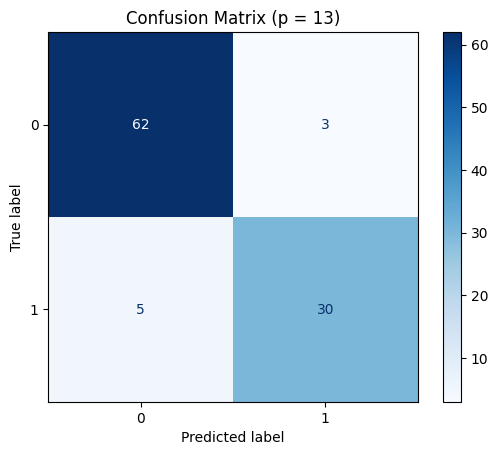

In [ ]:
# PCA with the best value of p

PCA_sst = PCA(n_components = best_p_value)
PCA_sst.fit(X)

Xp_sst = PCA_sst.transform(X)
X_train, X_test, y_train, y_test = useful_functions.split_scale_data(
    Xp_sst, y, RANDOM_SPLIT = False, train_size = 374, verbose = False
)
best_model_pca.fit(X_train, y_train)

# Make predictions 
y_test_pred = best_model_pca.predict(X_test)

# Print the scores
test_accuracy = accuracy_score(y_test, y_test_pred)
roc_auc_score_test = roc_auc_score(y_test, best_model_pca.predict_proba(X_test)[:, 1])
print(f"Test accuracy with the best p: {test_accuracy:.2f}")
print(f"Test auc with the best p: {roc_auc_score_test:.2f}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=lda.classes_)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix (p = {best_p_value})")
plt.show()

## 5) Neural Networks 